Machine Learning Foundations – Shallow Models Training, Validation and Tuning

---

This notebook implements:
1. Exploratory Data Analysis (EDA)
2. Data Splitting (Train/Validation/Test)
3. Feature Engineering
4. Baseline Model: Linear Regression
5. Random Forest Regressor (with feature importance)
6. Gradient Boosting Regressor (e.g., using XGBoost)
7. Hyperparameter tuning using RandomizedSearchCV (RF) and BayesSearchCV (Gradient Boosting)
8. Iterative refinement and final model selection (retraining on train+validation)

## Import Libraries
---
open a terminal and import the following libraries:
- pip install scikit-learn
- pip install scikit-optimize
- pip install datetime    
- pip install seaborn      
- pip install pandas   
- pip install xgboost

In [72]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

# Models and preprocessing
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor  # Install xgboost if not already installed
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# For encoding cyclical features
def encode_cyclical(data, col, period):
    data[col + '_sin'] = np.sin(2 * np.pi * data[col] / period)
    data[col + '_cos'] = np.cos(2 * np.pi * data[col] / period)
    return data

# For Bayesian Optimization tuning:
try:
    from skopt import BayesSearchCV
except ImportError:
    print("Please install scikit-optimize to run BayesSearchCV (pip install scikit-optimize)")

## 1. Exploratory Data Analysis (EDA)
 
In this section, we load the dataset (hour.csv) and perform a basic exploratory analysis including:
- Distribution analysis for the target variable (`cnt`)
- Examining the influence of temporal, binary, and weather-related features on the target
- Visualizations such as histograms, box plots, and time series plots

In [73]:
# Load the dataset.
data = pd.read_csv("hour.csv")

# Display basic information
print("Dataset shape:", data.shape)
print("First few rows:")
display(data.head())

# List columns to see available features
print("Columns:", data.columns.tolist())

Dataset shape: (17379, 17)
First few rows:


,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


Columns: ['instant', 'dteday', 'season', 'yr', 'mnth', 'hr', 'holiday', 'weekday', 'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed', 'casual', 'registered', 'cnt']


### 1.1 Examining the Target Variable (`cnt`)

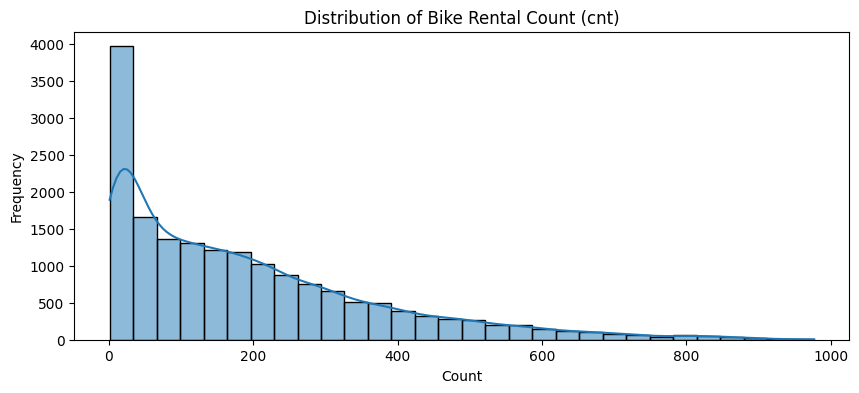

Skewness: 1.2774116037490577


In [74]:
# Plot the info
plt.figure(figsize=(10, 4))
sns.histplot(data['cnt'], kde=True, bins=30)
plt.title("Distribution of Bike Rental Count (cnt)")
plt.xlabel("Count")
plt.ylabel("Frequency")
plt.show()

print("Skewness:", data['cnt'].skew())

### 1.2 Explore Influences of Key Features

Visualize how temporal (e.g., `hr`, `weekday`, `mnth`, `season`), binary (e.g., `holiday`, `workingday`), and weather-related features (e.g., `temp`, `atemp`, `hum`, `windspeed`, `weathersit`) affect `cnt`.


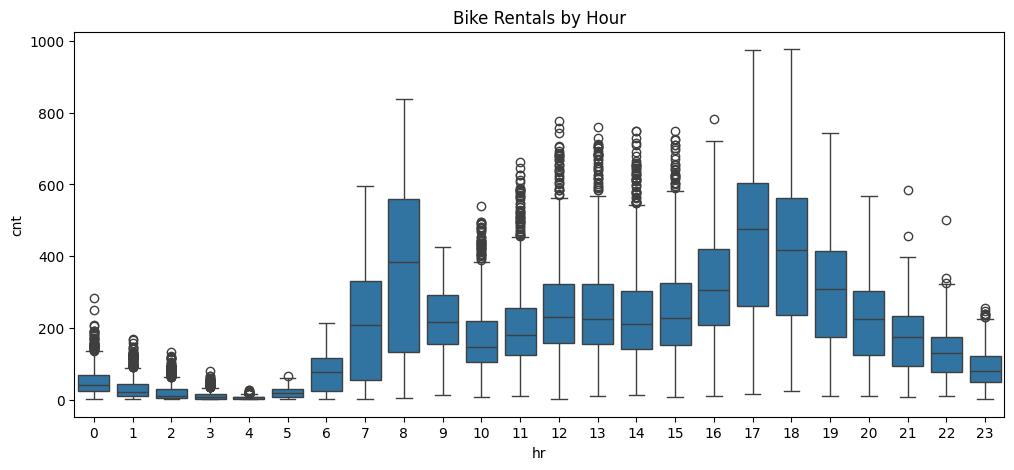

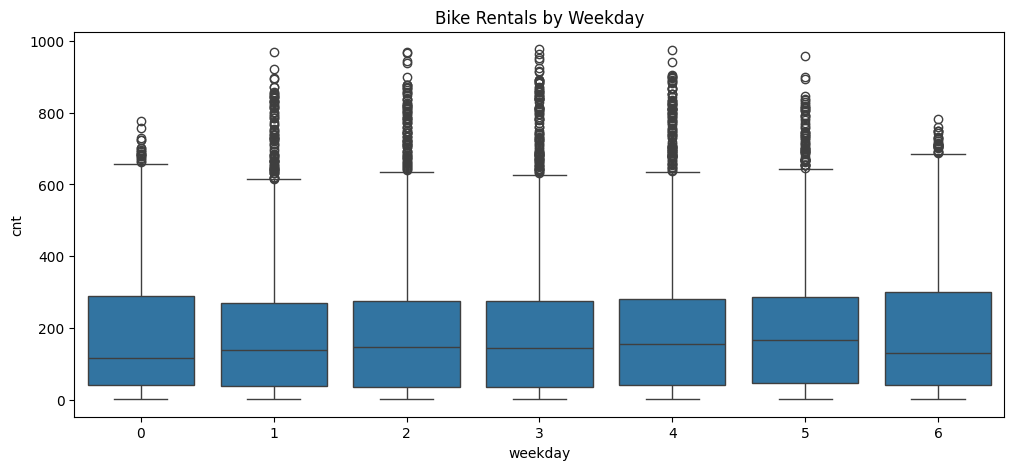

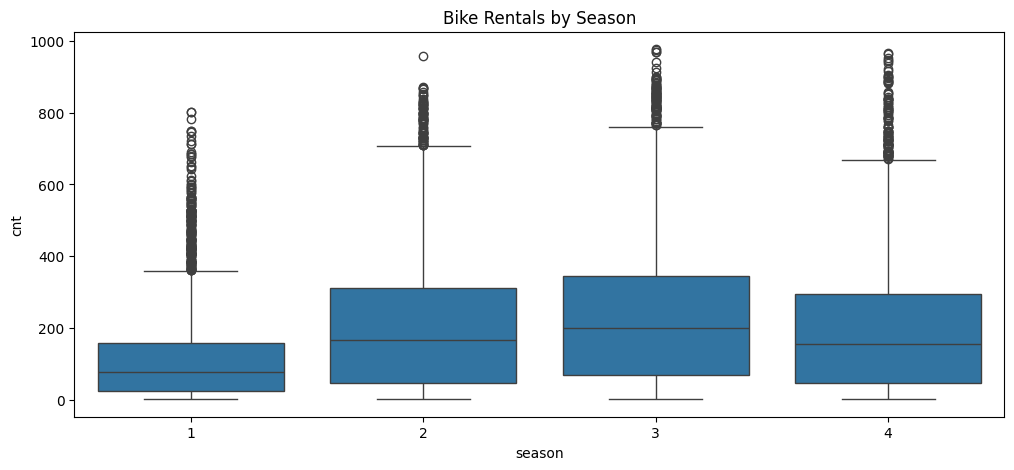

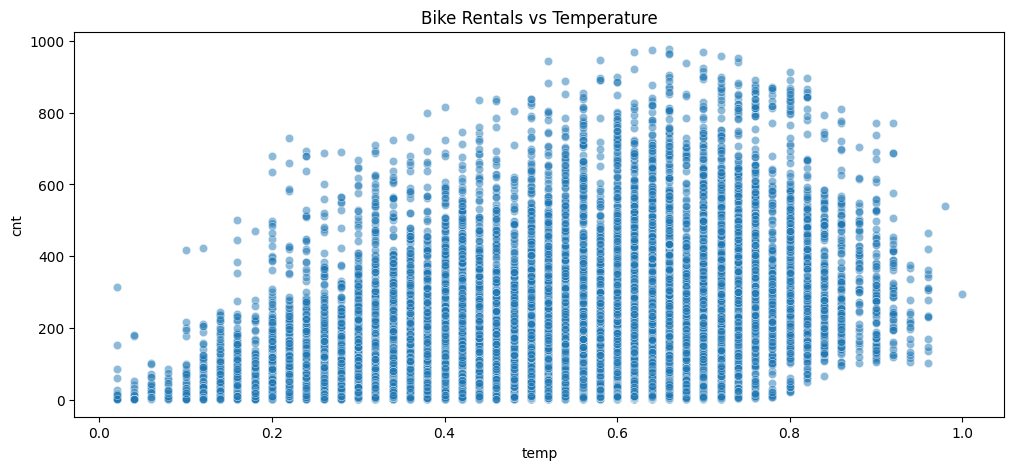

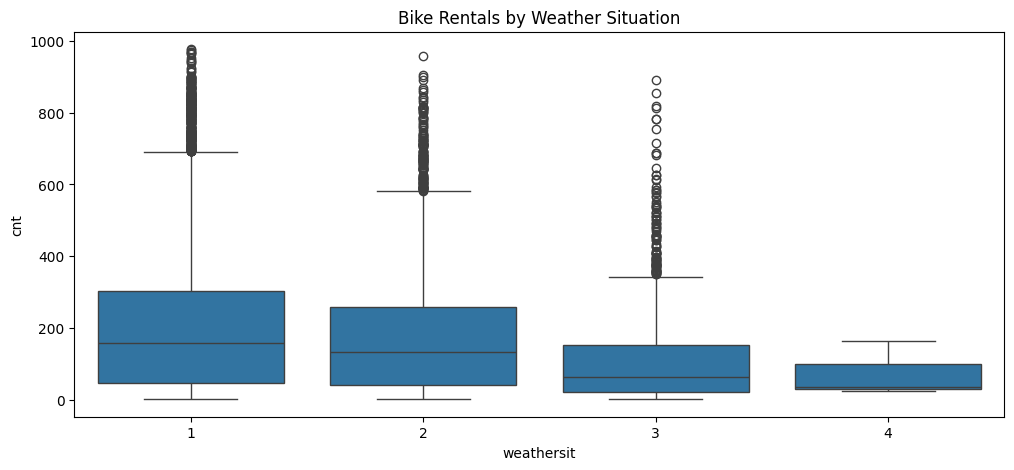

In [75]:
# Boxplot of rental counts by hour
plt.figure(figsize=(12, 5))
sns.boxplot(x='hr', y='cnt', data=data)
plt.title("Bike Rentals by Hour")
plt.show()

# Boxplot by weekday
plt.figure(figsize=(12, 5))
sns.boxplot(x='weekday', y='cnt', data=data)
plt.title("Bike Rentals by Weekday")
plt.show()

# Rentals by season
plt.figure(figsize=(12, 5))
sns.boxplot(x='season', y='cnt', data=data)
plt.title("Bike Rentals by Season")
plt.show()

# Scatter plot for temperature and count
plt.figure(figsize=(12, 5))
sns.scatterplot(x='temp', y='cnt', data=data, alpha=0.5)
plt.title("Bike Rentals vs Temperature")
plt.show()

# Rentals by weather situation
plt.figure(figsize=(12, 5))
sns.boxplot(x='weathersit', y='cnt', data=data)
plt.title("Bike Rentals by Weather Situation")
plt.show()

### 1.3 Identify and Remove Unwanted Features

Dropping non-informative or redundant columns:
- `instant` (ID)
- `dteday` (date as a string)
- `casual` and `registered` (since `cnt` is the sum of these)


In [76]:
data = data.drop(columns=["instant", "dteday", "casual", "registered"])
print("Updated columns:", data.columns.tolist())

Updated columns: ['season', 'yr', 'mnth', 'hr', 'holiday', 'weekday', 'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed', 'cnt']


## 2. Data Splitting

Split the data into train (60%), validation (20%), and test (20%) sets. It is important to perform 
the split before any feature engineering to prevent leakage.

In [77]:
# First, split off the test set (20%)
train_val, test = train_test_split(data, test_size=0.2, random_state=42)

# Then, split the remaining data into training (60% of total) and validation (20% of total)
# Since train_val is 80% of the data, validation is 0.25 of train_val to yield 20% overall.
train, val = train_test_split(train_val, test_size=0.25, random_state=42)

print("Training set shape:", train.shape)
print("Validation set shape:", val.shape)
print("Test set shape:", test.shape)

Training set shape: (10427, 13)
Validation set shape: (3476, 13)
Test set shape: (3476, 13)


## 3. Feature Engineering

Now we perform the following:
- Encode cyclical features (`hr` and `weekday`) using sine and cosine transforms.
- One-hot encode categorical features: `season`, `weathersit`, `mnth`.
- Scale continuous features (`temp`, `atemp`, `hum`, `windspeed`) using StandardScaler.
- (Optionally) Create interaction terms (e.g., `temp * hum`).
#
**Postata:** We fit the transformations on the training set and then apply the same transformation to validation and test sets.

In [78]:
# Make deep copies of datasets so that feature engineering can be applied independently.
train_fe = train.copy()
val_fe = val.copy()
test_fe = test.copy()

# 3.1 Encode cyclical features: 'hr' (period=24) and 'weekday' (period=7)
for df in [train_fe, val_fe, test_fe]:
    df = encode_cyclical(df, 'hr', 24)
    df = encode_cyclical(df, 'weekday', 7)
    
# For simplicity, here we add the new cyclic features manually.
# Later we drop the raw 'hr' and 'weekday' columns if desired.
for df in [train_fe, val_fe, test_fe]:
    df.drop(columns=['hr', 'weekday'], inplace=True)

# 3.2 One-hot encode categorical variables: 'season', 'weathersit', 'mnth'
categorical_cols = ['season', 'weathersit', 'mnth']
# We can use pandas get_dummies for simplicity.
train_fe = pd.get_dummies(train_fe, columns=categorical_cols, drop_first=True)
val_fe = pd.get_dummies(val_fe, columns=categorical_cols, drop_first=True)
test_fe = pd.get_dummies(test_fe, columns=categorical_cols, drop_first=True)

val_fe = val_fe.reindex(columns=train_fe.columns, fill_value=0)
test_fe = test_fe.reindex(columns=train_fe.columns, fill_value=0)

# Make sure all datasets have the same dummy columns:
train_cols = set(train_fe.columns)
for df in [val_fe, test_fe]:
    missing_cols = train_cols - set(df.columns)
    for col in missing_cols:
        df[col] = 0  # add missing column
    # Rearrange columns in the same order as the training set
    df = df[train_fe.columns]
    
# 3.3 Scale continuous features: 'temp', 'atemp', 'hum', 'windspeed'
scaler = StandardScaler()
continuous_cols = ['temp', 'atemp', 'hum', 'windspeed']

# Fit scaler only on training data
scaler.fit(train_fe[continuous_cols])

# Apply transformation to each set
for df in [train_fe, val_fe, test_fe]:
    df[continuous_cols] = scaler.transform(df[continuous_cols])
    
# 3.4 (Optional) Add interaction term: temp * hum, if useful
for df in [train_fe, val_fe, test_fe]:
    df['temp_x_hum'] = df['temp'] * df['hum']

# Separate features and target variable for each split
X_train = train_fe.drop(columns=["cnt"])
y_train = train_fe["cnt"]

X_val = val_fe.drop(columns=["cnt"])
y_val = val_fe["cnt"]

X_test = test_fe.drop(columns=["cnt"])
y_test = test_fe["cnt"]

print("Feature engineering complete. Example features:")
display(X_train.head())

Feature engineering complete. Example features:


,yr,holiday,workingday,temp,atemp,hum,windspeed,hr_sin,hr_cos,weekday_sin,...,mnth_4,mnth_5,mnth_6,mnth_7,mnth_8,mnth_9,mnth_10,mnth_11,mnth_12,temp_x_hum
807,0,0,0,-1.222871,-1.436707,-0.140903,1.127419,5.000000e-01,0.866025,0.000000,...,False,False,False,False,False,False,False,False,False,0.172306
8708,1,0,1,-1.843703,-2.227172,-1.229157,3.201003,-8.660254e-01,-0.500000,0.974928,...,False,False,False,False,False,False,False,False,False,2.266201
2818,0,0,1,-0.084677,-0.031951,0.740065,0.273302,8.660254e-01,-0.500000,0.781831,...,False,True,False,False,False,False,False,False,False,-0.062666
7269,0,0,1,-0.084677,-0.031951,-0.400011,2.468669,1.224647e-16,-1.000000,-0.974928,...,False,False,False,False,False,False,False,True,False,0.033872
1436,0,0,0,-1.015926,-1.085518,1.258281,0.028918,7.071068e-01,0.707107,-0.781831,...,False,False,False,False,False,False,False,False,False,-1.278320


## 4. Baseline Model – Linear Regression

Train the Linear Regression model and evaluate it on the validation set using:
- Mean Squared Error (MSE)
- Mean Absolute Error (MAE)
- R² Score

Also plot the residuals to analyze their distribution.


Linear Regression Performance on Validation Set:
MSE: 15301.530646223446
MAE: 90.41743720508846
R²: 0.5294149789428085


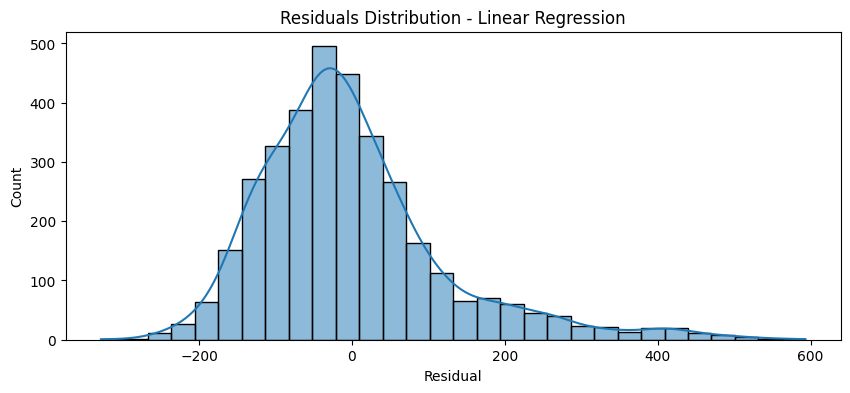

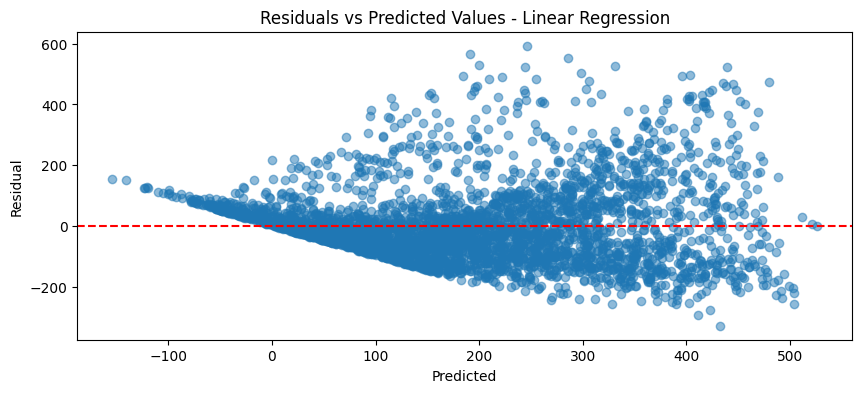

In [79]:
# Train Linear Regression on training data
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

# Predict on validation set
y_pred_lr = lin_reg.predict(X_val)

# Evaluate
mse_lr = mean_squared_error(y_val, y_pred_lr)
mae_lr = mean_absolute_error(y_val, y_pred_lr)
r2_lr  = r2_score(y_val, y_pred_lr)

print("Linear Regression Performance on Validation Set:")
print("MSE:", mse_lr)
print("MAE:", mae_lr)
print("R²:", r2_lr)

# Plot residuals
residuals_lr = y_val - y_pred_lr
plt.figure(figsize=(10, 4))
sns.histplot(residuals_lr, kde=True, bins=30)
plt.title("Residuals Distribution - Linear Regression")
plt.xlabel("Residual")
plt.show()

plt.figure(figsize=(10, 4))
plt.scatter(y_pred_lr, residuals_lr, alpha=0.5)
plt.axhline(y=0, color='red', linestyle='--')
plt.title("Residuals vs Predicted Values - Linear Regression")
plt.xlabel("Predicted")
plt.ylabel("Residual")
plt.show()

## 5. Random Forest Regressor

Train a Random Forest Regressor with default parameters and compare its performance to the baseline.

Random Forest Performance on Validation Set:
MSE: 1941.03223446487
MAE: 26.951583237437664
R²: 0.9403052729790938


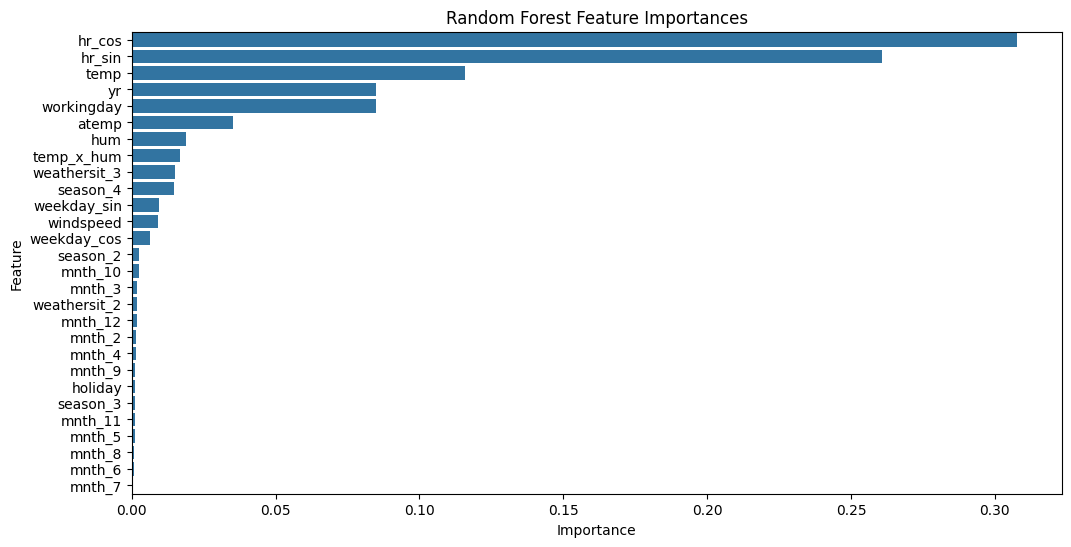

In [80]:
# Train Random Forest Regressor on training data with default parameters
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predict on validation set
y_pred_rf = rf_model.predict(X_val)

# Evaluate
mse_rf = mean_squared_error(y_val, y_pred_rf)
mae_rf = mean_absolute_error(y_val, y_pred_rf)
r2_rf  = r2_score(y_val, y_pred_rf)

print("Random Forest Performance on Validation Set:")
print("MSE:", mse_rf)
print("MAE:", mae_rf)
print("R²:", r2_rf)

# Feature importance plot
importances = rf_model.feature_importances_
features = X_train.columns
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(12, 6))
sns.barplot(x=importances[indices], y=features[indices])
plt.title("Random Forest Feature Importances")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()

## 6. Gradient Boosting Regressor (XGBoost)

Now Train an XGBoost regressor with basic parameters to get an initial benchmark.

XGBoost Performance on Validation Set:
MSE: 1767.1717529296875
MAE: 26.49593162536621
R²: 0.945652186870575


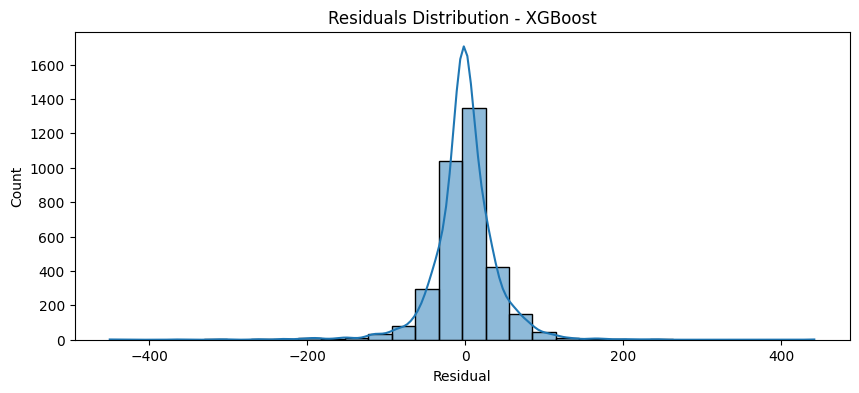

In [81]:
# Train the XGBoost regressor with basic parameters
xgb_model = XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42)
xgb_model.fit(X_train, y_train)

# Predict on validation set
y_pred_xgb = xgb_model.predict(X_val)

# Evaluate
mse_xgb = mean_squared_error(y_val, y_pred_xgb)
mae_xgb = mean_absolute_error(y_val, y_pred_xgb)
r2_xgb  = r2_score(y_val, y_pred_xgb)

print("XGBoost Performance on Validation Set:")
print("MSE:", mse_xgb)
print("MAE:", mae_xgb)
print("R²:", r2_xgb)

# Plot residuals
residuals_xgb = y_val - y_pred_xgb
plt.figure(figsize=(10, 4))
sns.histplot(residuals_xgb, kde=True, bins=30)
plt.title("Residuals Distribution - XGBoost")
plt.xlabel("Residual")
plt.show()

## 7. Hyperparameter Tuning

Perform hyperparameter tuning on the Random Forest and the XGBoost models.

### 7.1 Tuning Random Forest using RandomizedSearchCV


In [82]:
# Define parameter grid for Random Forest
param_grid_rf = {
    'n_estimators': [100, 200, 300, 400],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf_random_search = RandomizedSearchCV(
    estimator=RandomForestRegressor(random_state=42),
    param_distributions=param_grid_rf,
    n_iter=20,
    cv=5,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

rf_random_search.fit(X_train, y_train)
print("Best parameters for Random Forest:", rf_random_search.best_params_)

# Evaluate the best RF model on validation set
best_rf = rf_random_search.best_estimator_
y_pred_best_rf = best_rf.predict(X_val)
mse_best_rf = mean_squared_error(y_val, y_pred_best_rf)
mae_best_rf = mean_absolute_error(y_val, y_pred_best_rf)
r2_best_rf  = r2_score(y_val, y_pred_best_rf)

print("Tuned Random Forest Performance on Validation Set:")
print("MSE:", mse_best_rf)
print("MAE:", mae_best_rf)
print("R²:", r2_best_rf)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best parameters for Random Forest: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 20}
Tuned Random Forest Performance on Validation Set:
MSE: 1900.4036438953333
MAE: 26.758850732774224
R²: 0.9415547692935955


### 7.2 Tuning XGBoost using BayesSearchCV

For Bayesian optimization, we use BayesSearchCV from scikit-optimize.


In [83]:
# Define parameter search space for XGBoost
# Note: The search spaces can be defined as tuples (min, max) or lists of discrete values.
param_space_xgb = {
    'learning_rate': (0.01, 0.3, 'uniform'),
    'n_estimators': (50, 300),
    'max_depth': (3, 10),
    'subsample': (0.5, 1.0, 'uniform')
}

# Initialize BayesSearchCV
try:
    bayes_search_xgb = BayesSearchCV(
        estimator=XGBRegressor(objective='reg:squarederror', random_state=42),
        search_spaces=param_space_xgb,
        n_iter=20,
        cv=5,
        random_state=42,
        n_jobs=-1,
        verbose=0
    )
    
    bayes_search_xgb.fit(X_train, y_train)
    print("Best parameters for XGBoost:", bayes_search_xgb.best_params_)
    
    # Evaluate the tuned XGBoost model on validation set
    best_xgb = bayes_search_xgb.best_estimator_
    y_pred_best_xgb = best_xgb.predict(X_val)
    mse_best_xgb = mean_squared_error(y_val, y_pred_best_xgb)
    mae_best_xgb = mean_absolute_error(y_val, y_pred_best_xgb)
    r2_best_xgb  = r2_score(y_val, y_pred_best_xgb)
    
    print("Tuned XGBoost Performance on Validation Set:")
    print("MSE:", mse_best_xgb)
    print("MAE:", mae_best_xgb)
    print("R²:", r2_best_xgb)
    
except Exception as e:
    print("BayesSearchCV encountered an error. Please ensure scikit-optimize is installed.")
    print(e)

Best parameters for XGBoost: OrderedDict([('learning_rate', 0.039472860233890864), ('max_depth', 10), ('n_estimators', 300), ('subsample', 0.5)])
Tuned XGBoost Performance on Validation Set:
MSE: 1548.311767578125
MAE: 24.024471282958984
R²: 0.9523830413818359


## 8. Iterative Evaluation and Refinement

At this stage, based on the evaluation metrics and residual analysis, I decided to:
- Revisit feature engineering (e.g., adding or removing interaction terms)
- Address any outliers
- Modify model complexity

A summary of validation performances is printed for all three models (initial and tuned):
- Linear Regression
- Random Forest (initial and tuned)
- XGBoost (initial and tuned)


## 9. Final Model Selection and Testing

Based on the validation performance, Select the model with the best bias/variance trade-off.
Here I show the retraining the chosen model on the combined training and validation sets and then evaluating on the test set.


Final Model Performance on Test Set:
MSE: 1452.0977783203125
MAE: 22.49738883972168
R²: 0.9541424512863159


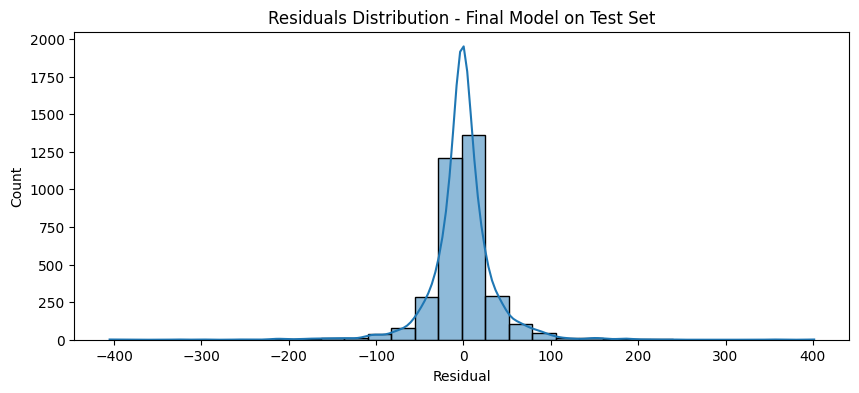

In [84]:
# Combine training and validation sets
train_val_combined = pd.concat([train_fe, val_fe], axis=0)
X_train_val = train_val_combined.drop(columns=["cnt"])
y_train_val = train_val_combined["cnt"]

# Suppose the tuned XGBoost performed best (alternatively, choose best_rf if that performed better)
final_model = best_xgb  # or best_rf for Random Forest, or another model

# Retrain final model on combined training+validation data
final_model.fit(X_train_val, y_train_val)

# Evaluate on the test set
y_pred_test = final_model.predict(X_test)
mse_test = mean_squared_error(y_test, y_pred_test)
mae_test = mean_absolute_error(y_test, y_pred_test)
r2_test  = r2_score(y_test, y_pred_test)

print("Final Model Performance on Test Set:")
print("MSE:", mse_test)
print("MAE:", mae_test)
print("R²:", r2_test)

# Plot residuals for test predictions
residuals_test = y_test - y_pred_test
plt.figure(figsize=(10, 4))
sns.histplot(residuals_test, kde=True, bins=30)
plt.title("Residuals Distribution - Final Model on Test Set")
plt.xlabel("Residual")
plt.show()

## Conclusion

- Performed detailed EDA and visualized important patterns in the dataset.
- Split the dataset into training, validation, and test sets to avoid data leakage.
- Engineered features by encoding cyclical variables, applying one-hot encoding, and scaling continuous features.
- Built a baseline Linear Regression model and two more complex models (Random Forest and XGBoost) for regression.
- Tuned hyperparameters using RandomizedSearchCV (for Random Forest) and BayesSearchCV (for XGBoost).
- Selected the best model based on validation performance, retrained on combined data, and tested its generalization ability on the test set.

The final evaluation metrics on the test set are documented above. 
